In [1]:
#import matplotlib as matplot
#import seaborn
#import bokeh
#import keras
#import scipy
import pandas as pd
import numpy as np
import networkx as nx
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go
import graphviz
from ncs1_import import ncs1_data
from ncsr_import import ncsr_data
import re
import copy
import pathpy as pp
import matplotlib.pyplot as plt
# For color mapping
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.lines as mlines
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
# import block

In [2]:
# Pull ncsr data from file ncsr_import
ncsr = ncsr_data()
  # ncsr.ncsr holds all of the data from NCS 20240
  # https://www.icpsr.umich.edu/web/ICPSR/studies/20240
  # Alegria, Margarita, Jackson, James S. (James Sidney), Kessler, Ronald C., and Takeuchi, David. Collaborative Psychiatric Epidemiology Surveys (CPES), 2001-2003 [United States]. Ann Arbor, MI: Inter-university Consortium for Political and Social Research [distributor], 2016-03-23. https://doi.org/10.3886/ICPSR20240.v8
  # Key Functions:
    # ncsr.search_for_description looks for a descriotion of a column name in ncs1.dxdm or ncs1.survey
    # ncsr.get_variable_info queries icpsr for information like values, variable descriptions, and more
    # ncsr.get_value_from_string takes in a string that is a var name of dataframe in the ncsr description tree. Tree can be traversed using ncsr.root
  # Key Variables:
    # ncsr.ncsr 
    # ncsr.tree (Tree including descriptions of survey and dxdm columns)
    # ncsr.root (root used in traversing ncsr.tree)

C:\Users\galyn\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3427: DtypeWarning:

Columns (910,953,3340,3518,3573,3581,3582,3583,3584,3616,3620,3711) have mixed types.Specify dtype option on import or set low_memory=False.



In [8]:
 ncsr.get_value_from_string(ncsr.root.iloc[3,0])[ncsr.get_value_from_string(ncsr.root.iloc[3,0])['Description'].str.match(".*.*", False)]

,VarName,Description,Root_DF,Start,End,DataFrame,recursion_flag
0,IR1A,Other problems during irritable episode,Irritable_Depression,364,364,ncsr,0
1,IR1B,Other problems during irritable episode for se...,Irritable_Depression,365,365,ncsr,0
2,IR2,Period of being irritable + other problems for...,Irritable_Depression,366,366,ncsr,0
3,IR2A,Longest # days when irritable + other probs mo...,Irritable_Depression,367,367,ncsr,0
4,IR4,Irritable + other probs sev days every mth of ...,Irritable_Depression,368,368,ncsr,0
...,...,...,...,...,...,...,...
75,IR71,Hospitalized overnight for irritability,Irritable_Depression,439,439,ncsr,0
76,IR71A,Age 1st time hospitalized overnight for irrita...,Irritable_Depression,440,440,ncsr,0
77,IR71_1,# close relatives had irritable episode,Irritable_Depression,441,441,ncsr,0
78,IR20B,About how old first time had an episode of thi...,Irritable_Depression,442,442,ncsr,0


In [7]:
ncsr.get_value_from_string(ncsr.root.iloc[3,0])

,VarName,Description,Root_DF,Start,End,DataFrame,recursion_flag
0,IR1A,Other problems during irritable episode,Irritable_Depression,364,364,ncsr,0
1,IR1B,Other problems during irritable episode for se...,Irritable_Depression,365,365,ncsr,0
2,IR2,Period of being irritable + other problems for...,Irritable_Depression,366,366,ncsr,0
3,IR2A,Longest # days when irritable + other probs mo...,Irritable_Depression,367,367,ncsr,0
4,IR4,Irritable + other probs sev days every mth of ...,Irritable_Depression,368,368,ncsr,0
...,...,...,...,...,...,...,...
75,IR71,Hospitalized overnight for irritability,Irritable_Depression,439,439,ncsr,0
76,IR71A,Age 1st time hospitalized overnight for irrita...,Irritable_Depression,440,440,ncsr,0
77,IR71_1,# close relatives had irritable episode,Irritable_Depression,441,441,ncsr,0
78,IR20B,About how old first time had an episode of thi...,Irritable_Depression,442,442,ncsr,0


In [25]:
for dsm in ncsr.get_value_from_string(ncsr.root.iloc[43,0]).iloc[:,0]:
    print(ncsr.search_for_description(dsm)[1], " | ", len(ncsr.ncsr[ncsr.ncsr.loc[:, dsm] == 1].reset_index(drop=True)))

DSM-IV Attention Deficit Disorder (LifeT)  |  365
DSM-IV Agoraphobia without Panic Disorder (LifeT)  |  231
DSM-IV Agoraphobia with Panic Disorder (LifeT)  |  126
DSM-IV Alcohol Abuse (Lifetime)  |  1034
Lifetime Alcohol Abuse w/ hierarchy  |  590
DSM-IV Alcohol Dependence (Lifetime)  |  444
DSM-IV Adult Separation Anxiety Disorder (LifeT)  |  558
DSM-IV Bi-Polar I (Lifetime)  |  101
DSM-IV Bi-Polar II (Lifetime)  |  105
Lifetime Bi-Polar Subthreshold  |  210
DSM-IV Conduct Disorder (Lifetime)  |  405
DSM-IV Drug Abuse (Lifetime)  |  651
DSM-IV Drug Dependence (Lifetime)  |  248
DSM-IV Dysthymia (Lifetime)  |  386
DSM-IV Dysthymia with hierarchy (LifeT)  |  232
DSM-IV Generalized Anxiety Disorder (LifeT)  |  752
DSM-IV Gen Anxiety Disorder w/hierarchy (LifeT)  |  553
DSM-IV Hypomania (Lifetime)  |  77
DSM-IV Intermittent Explosive Disorder (LifeT)  |  728
DSM-IV Intermittent Explosive Disorder w/ hierarchy (LifeT)  |  678
DSM-IV Mania (Lifetime)  |  339
DSM-IV Major Depressive Disorder

In [19]:
ncsr.get_value_from_string(ncsr.root.iloc[43,0]).iloc[: 0:2]

,VarName,Description
0,DSM_ADD,DSM-IV Attention Deficit Disorder (LifeT)
1,DSM_AGO,DSM-IV Agoraphobia without Panic Disorder (LifeT)
2,DSM_AGP,DSM-IV Agoraphobia with Panic Disorder (LifeT)
3,DSM_ALA,DSM-IV Alcohol Abuse (Lifetime)
4,DSM_ALAH,Lifetime Alcohol Abuse w/ hierarchy
...,...,...
350,HHSIZE,Total number of HH members
351,WEIGHT,Weight in pounds
352,HEIGHT,Total height-inches
353,RANCEST,Race/Ancestry


In [73]:
# below code is used to cut out variables that have do do with onset age of symptoms
age_variable_subset = pd.DataFrame(columns = ['VarName', 'Description', 'Root_DF', 'Start', 'End', 'DataFrame', 'recursion_flag'])
#b = pd.DataFrame(columns = ['VarName', 'Description', 'Root_DF', 'Start', 'End', 'DataFrame', 'recursion_flag'])
#c = pd.DataFrame(columns = ['VarName', 'Description', 'Root_DF', 'Start', 'End', 'DataFrame', 'recursion_flag'])

for x in range(1, len(ncsr.root)):
    age_variable_subset = age_variable_subset.append(
        ncsr.get_value_from_string(ncsr.root.iloc[x,0])[
            np.array(ncsr.get_value_from_string(ncsr.root.iloc[x,0])['Description'].str.match(".*.*", False)) & np.array(ncsr.get_value_from_string(ncsr.root.iloc[x,0])['Description'].str.match(".*(^Age |^Age| age )+.*", False)) & np.logical_not(np.array(ncsr.get_value_from_string(ncsr.root.iloc[x,0])['Description'].str.match(".*(^Remember|^Exact|^Age$|#|biological|when you were born)+.*", False)))
            ]
    )
   ##  this checks each regex to see the variables gut out. pd.concat below checks the difference between DFs
    #b = b.append(
   #     ncsr.get_value_from_string(ncsr.root.iloc[x,0])[
   #         np.array(ncsr.get_value_from_string(ncsr.root.iloc[x,0])[
   #             'Description'].str.match(".*(first|1st|onset)+.*", False)) & np.array(ncsr.get_value_from_string(ncsr.root.iloc[x,0])[
   #                 'Description'].str.match(".*(^Age |^Age| age | age|age | old|old | old |^DSM|^ICD)+.*", False))
   #         ]
   # )
   # c = c.append(
   #     ncsr.get_value_from_string(ncsr.root.iloc[x,0])[
   #         np.array(ncsr.get_value_from_string(ncsr.root.iloc[x,0])['Description'].str.match(".*(first|1st|onset)+.*", False))
   #         ]
   # )
   # pd.concat([,c]).drop_duplicates(keep=False).to_csv('out.csv')
age_variable_subset = age_variable_subset.reset_index(drop=True)

age_variable_subset


,VarName,Description,Root_DF,Start,End,DataFrame,recursion_flag
0,D22A,Age worst episode began,Depression,171,171,ncsr,0
1,D22C,Age of last bad sadness/depressed episode,Depression,174,174,ncsr,0
2,D37A,Age 1st depressed episode,Depression,225,225,ncsr,0
3,D37B,Estimate age 1st episode,Depression,226,226,ncsr,0
4,D38C,Age last time with episode,Depression,240,240,ncsr,0
...,...,...,...,...,...,...,...
303,EA26A,Age 1st used weight control method for 3+ mths,Eating_Disorder,3342,3342,ncsr,0
304,EA26B1,Estimate age used weight control method for 3+...,Eating_Disorder,3343,3343,ncsr,0
305,EA29A,Age last used weight control strategy,Eating_Disorder,3346,3346,ncsr,0
306,EA35A,Age 1st saw doctor for eating problems,Eating_Disorder,3353,3353,ncsr,0


In [35]:
ncsr_age = pd.read_csv('initialized_age_vars.csv', index_col=0)
ncsr_age

,CASEID,D22A,D22C,D37A,D37B,D38C,D42,D47,D59A,D72A,...,EA15A,EA19A,EA19B,EA19B1,EA22A,EA26A,EA26B1,EA29A,EA35A,EA37A
0,1,35,-1,34,-1,40,-1,-1,34,35,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,3,77,-1,77,-1,-1,-1,-1,77,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,4,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9277,9278,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
9278,9279,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
9279,9280,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
9280,9281,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [61]:
diag1 = "DSM_GAD"
diag2 = "DSM_MDDH"
gad_subset = ncsr_age[(ncsr.ncsr.loc[:, diag1] == 1)]
mdd_subset = ncsr_age[(ncsr.ncsr.loc[:, diag2] == 1)]


comorbid_subset_vals = [x for x in gad_subset.index if x in mdd_subset.index]



In [63]:
comorbid_subset = mdd_subset.loc[comorbid_subset_vals, :]

In [67]:
comorbid_subset = comorbid_subset.reset_index(drop=True)

In [71]:
comorbid_subset


,CASEID,D22A,D22C,D37A,D37B,D38C,D42,D47,D59A,D72A,...,EA15A,EA19A,EA19B,EA19B1,EA22A,EA26A,EA26B1,EA29A,EA35A,EA37A
0,1,35,-1,34,-1,40,-1,-1,34,35,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,124,19,-1,19,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,153,35,-1,35,-1,23,-1,-1,23,35,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,173,-1,35,34,-1,35,-1,-1,-1,35,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,187,43,-1,31,-1,43,-1,-1,-1,31,...,-1,22,-1,-1,51,-1,-1,-1,21,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,9187,-1,27,-1,-1,-1,-1,-1,24,24,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
375,9238,46,-1,46,-1,46,-1,-1,-1,47,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
376,9250,47,-1,26,-1,46,-1,-1,27,47,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
377,9256,22,-1,19,-1,-1,-1,-1,-1,11,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [68]:
ncsr.get_value_from_string(ncsr.root.iloc[43,0])

,VarName,Description,Root_DF,Start,End,DataFrame,recursion_flag
0,DSM_ADD,DSM-IV Attention Deficit Disorder (LifeT),Supplemental,3359,3359,ncsr,0
1,DSM_AGO,DSM-IV Agoraphobia without Panic Disorder (LifeT),Supplemental,3360,3360,ncsr,0
2,DSM_AGP,DSM-IV Agoraphobia with Panic Disorder (LifeT),Supplemental,3361,3361,ncsr,0
3,DSM_ALA,DSM-IV Alcohol Abuse (Lifetime),Supplemental,3362,3362,ncsr,0
4,DSM_ALAH,Lifetime Alcohol Abuse w/ hierarchy,Supplemental,3363,3363,ncsr,0
...,...,...,...,...,...,...,...
350,HHSIZE,Total number of HH members,Supplemental,3709,3709,ncsr,0
351,WEIGHT,Weight in pounds,Supplemental,3710,3710,ncsr,0
352,HEIGHT,Total height-inches,Supplemental,3711,3711,ncsr,0
353,RANCEST,Race/Ancestry,Supplemental,3712,3712,ncsr,0


For above ^ chose the filter based on a staged approach identifying variables that had ages and whittlling it down checking with concat()

In [69]:


add_subset = copy.deepcopy(comorbid_subset)

In [74]:
# Go in and pull out the variables for a subject that are valid and in a 
for y in range(0, len(add_subset)):
    current_case = y
    case_age_vars = []
    for val, x in enumerate(age_variable_subset.iloc[:, 0]): 
            if add_subset.loc[y, x] != ' ':
                if add_subset.loc[y, x] != '.' and int(add_subset.loc[y,x]) > 1 and int(add_subset.loc[y,x]) < 100:
                    add_subset.loc[y, x] = int(add_subset.loc[y,x])
                else: 
                    add_subset.loc[y, x] = -1
            else:
                add_subset.loc[y,x] = -1

    #add_subset_correct_vars.append(case_age_vars.append(age_variable_subset.loc[y, "CASEID"]))

add_subset


KeyboardInterrupt: 

In [19]:
add_subset.to_csv('initialized_age_vars.csv')

Error: Pip module Unable to parse debugpy output, please log an issue with https://github.com/microsoft/vscode-jupyter is required for debugging cells. You will need to install it to debug cells.

In [76]:
add_edges_init = pd.DataFrame(0, columns = age_variable_subset.iloc[:,0], index=age_variable_subset.iloc[:,0])


In [77]:
average_onset_age_init = {}
for x in add_edges_init:
    average_onset_age_init[x] = 0

In [78]:
import copy

In [79]:
add_edges = add_edges_init.copy(deep=True)
average_onset = copy.deepcopy(average_onset_age_init)
onset_count = copy.deepcopy(average_onset_age_init)
add_edges.loc["PR4A", "SP7A1"]

0

In [80]:
add_graphs = []
for case in range(len(add_subset)):
    case_number = add_subset.iloc[case, 0]
    ordered_vals =[]
    ordered_vars = []
    vals = []
    case_age_vars = []
    for symptom in add_subset:
        if symptom != "CASEID":
            if add_subset.loc[case, symptom] > 0:
                vals.append(add_subset.loc[case, symptom])
                case_age_vars.append(symptom)
    # initialize the ordered lists
    #order ints by age symptom occured
    for x in range(0, len(vals)):
        m = vals.index(min(vals))
        ordered_vals.append(vals[m])
        ordered_vars.append(case_age_vars[m])
        del vals[m]
        del case_age_vars[m]

    G = nx.DiGraph()
    for x in range(0, len(ordered_vals)):
        G.add_node(ordered_vars[x], age = ordered_vals[x])
    mult_flag = 0
    back_start = -1
    back_end = -1
    back_flag = 0
    start = 0
    for x in range(0, len(ordered_vars)-1):
        if ordered_vals[x] != ordered_vals[x+1]:
            if not mult_flag:
                G.add_edges_from([(ordered_vars[x], ordered_vars[x+1])])
                back_flag = 0
            else: 
                for y in range(start, x+1):
                    G.add_edges_from([(ordered_vars[y], ordered_vars[x+1])])
                    back_flag = 1
                    back_end = x
            back_start = start
            start = x + 1
            mult_flag = 0
        elif ordered_vals[x] == ordered_vals[x+1]:
            mult_flag = 1
            if back_start<0:
                continue
            if back_flag: 
                for y in range(back_start, back_end + 1):
                    G.add_edges_from([(ordered_vars[y], ordered_vars[x+1])])
            else:
                G.add_edges_from([(ordered_vars[back_start], ordered_vars[x+1])]) 

    add_graphs.append(G)

for x in add_graphs: 
    node_age_added = []
    for from_node in age_variable_subset.iloc[:,0]:
        for to_node in age_variable_subset.iloc[:,0]:
            if x.has_edge(from_node, to_node):
                if from_node not in node_age_added: 
                    onset_count[from_node] += 1
                    average_onset[from_node] += x.nodes[from_node]['age']
                    node_age_added.append(from_node)
                if to_node not in node_age_added:
                    onset_count[to_node] += 1
                    average_onset[to_node] += x.nodes[to_node]['age']
                    node_age_added.append(to_node)
                
                add_edges.loc[from_node, to_node] += 1

In [81]:
for var, val in onset_count.items(): 
    if val > 0: 
        average_onset[var] = average_onset[var]/val

In [82]:
for x in range(len(add_edges)):
    for y in range(len(add_edges)):
        add_edges.iloc[x, y] = add_edges.iloc[x, y]/len(add_subset)


In [83]:
num = 0
main_graph = nx.DiGraph()
added_nodes = []
count = 0
for x in add_edges:
    for y in add_edges:
        if add_edges.loc[x, y] > .12: 
            count+=1
            if x not in added_nodes:
                main_graph.add_node(x)
                added_nodes.append(x)
            if y not in added_nodes:
                main_graph.add_node(y)
                added_nodes.append(y)
            main_graph.add_edges_from([(x, y)], weight = add_edges.loc[x, y]*50)
print(added_nodes)

['SU1', 'SU2A', 'MR1_2', 'CN3', 'SU87A', 'EM1', 'DM_EM1', 'SU87B', 'PR2', 'PR4A', 'MR19', 'DM_MR19', 'CH30_1A', 'CH30_1B']


vals = list(ncsr.ncsr.loc[current_case, case_age_vars]) # get all of the values for the case_age_vars
vals = [int(i) for i in vals] # make sure that the vals are ints

ordered_vals =[]
ordered_vars = []
  # initialize the ordered lists

#order ints by age symptom occured
for x in range(0, len(vals)):
    m = vals.index(min(vals))
    ordered_vals.append(vals[m])
    ordered_vars.append(case_age_vars[m])
    del vals[m]
    del case_age_vars[m]

G = nx.DiGraph()
for x in range(0, len(ordered_vals)):
    G.add_node(ordered_vars[x], age = ordered_vals[x])
flag = 1
back_start = -1
back_flag = 0
start = -1
for x in range(1, len(ordered_vars)):
    print(ordered_vars[x], flag, start, back_flag,  back_start)
    print(ordered_vals[x], ordered_vals[x-1])
    if ordered_vals[x-1] != ordered_vals[x] and flag == 1:
        if back_flag: 
            for y in range(back_start, x):
                #print("G.add_edges_from([(ordered_vars["+str(y)+"], ordered_vars["+str(x)+"])])")
                G.add_edges_from([(ordered_vars[y], ordered_vars[x])])
        else: 
            G.add_edges_from([(ordered_vars[x-1], ordered_vars[x])])
        back_start=start
        start = x
        back_flag = 0
        flag = 1
    elif x + 1 == len(ordered_vals) and flag == 0:
        if back_flag:
            for y in range(back_start, start):
                for z in range(start, x):
                    G.add_edges_from([(ordered_vars[y], ordered_vars[z]), (ordered_vars[z], ordered_vars[x])])
        else:
            for y in range(start, x):
                G.add_edges_from([(ordered_vars[start], ordered_vars[y]), (ordered_vars[y], ordered_vars[x])])
        start = x
    elif x + 1 == len(ordered_vals) and flag == 1:
        if back_flag: 
            for y in range(back_start, x):
                G.add_edges_from([(ordered_vars[y], ordered_vars[x])])
        else: 
            G.add_edges_from([(ordered_vars[x-1], ordered_vars[x])])
        start =x
    elif ordered_vals[x-1] != ordered_vals[x] and start == -1: 
        start = x
        for y in range(0, x):
           G.add_edges_from([(ordered_vars[y], ordered_vars[x])])
        back_flag = 0
        back_start = 0
    elif ordered_vals[x-1] != ordered_vals[x] and flag == 0: 
        if back_flag:
            for y in range(back_start, start):
                for z in range(start, x):
                    G.add_edges_from([(ordered_vars[y], ordered_vars[z]), (ordered_vars[z], ordered_vars[x])])
        else:
            for y in range(start, x):
                G.add_edges_from([(ordered_vars[start], ordered_vars[y]), (ordered_vars[y], ordered_vars[x])])
        flag = 1
        back_start = start
        start = x
        back_flag = 1
    else:
        flag = 0
        

G = copy.deepcopy(main_graph)
for x in range(0, len(ordered_vals)):
    G.add_node(ordered_vars[x], age = ordered_vals[x])
mult_flag = 0
back_start = -1
back_end = -1
back_flag = 0
start = 0
for x in range(0, len(ordered_vars)-1):
    if ordered_vals[x] != ordered_vals[x+1]:
        if not mult_flag:
            G.add_edges_from([(ordered_vars[x], ordered_vars[x+1])])
            back_flag = 0
        else: 
            for y in range(start, x+1):
                G.add_edges_from([(ordered_vars[y], ordered_vars[x+1])])
                back_flag = 1
                back_end = x
        back_start = start
        start = x + 1
        mult_flag = 0
    elif ordered_vals[x] == ordered_vals[x+1]:
        mult_flag = 1
        if back_start<0:
            continue
        if back_flag: 
            for y in range(back_start, back_end + 1):
                G.add_edges_from([(ordered_vars[y], ordered_vars[x+1])])
        else:
            G.add_edges_from([(ordered_vars[back_start], ordered_vars[x+1])]) 
    

add_graphs.append(G)


import matplotlib.pyplot as plt
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
#import pygraphviz
#pos = nx.drawing.nx_agraph.graphviz_layout(G)
#pos = nx.kamada_kawai_layout(G, pos = nx.spring_layout(G, k=3, iterations=10, dim=2, seed = 3))
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go
G = nx.read_gpickle('graph.pkl')
pos = graphviz_layout(G, 'dot')
for n, p in pos.items():
    G.nodes[n]['pos'] = p

edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=1,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])



node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='RdBu',
        #reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=10,
            title='Age',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=0)))

for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])


for x in G.nodes(data = True):
    node_trace['marker']['color']+=tuple([x[1]['age']])
    node_info = x[0] +' Age: '+str(x[1]['age'])
    node_trace['text']+=tuple([node_info])


fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Network for CASEID 445',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="",
                    showarrow=False,
                    xref="paper", yref="paper") ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

iplot(fig)


<Figure size 432x288 with 0 Axes>

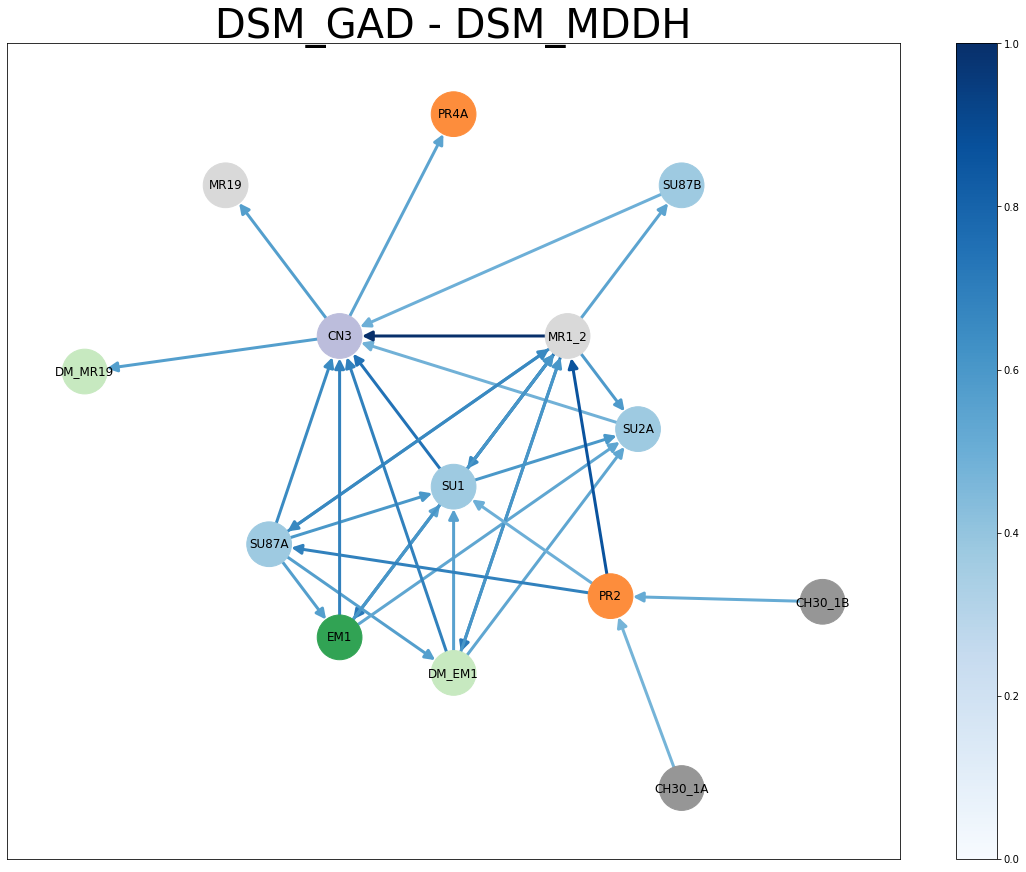

In [86]:
#G = nx.read_gpickle('graph.pkl')
G = main_graph
#pos = nx.kamada_kawai_layout(G, pos = nx.spring_layout(G, k = .15, iterations = 100, seed = 10020) )#

pos = graphviz_layout(G, prog="twopi")
#pos = nx.spring_layout(G, k = 4, iterations = 100, seed = 10020)
levels = []
vals = {}
for x in list(G.nodes):
    try:
        levels.append(list(ncsr.search_for_description(x)[1:3]))
        vals[x] = ncsr.search_for_description(x)[2]
    except: 
        levels.append(1)
level_set = list(set([x[1] for x in levels]))
for x in levels: 
    x[1] = level_set.index(x[1]) + 1

level_vals = [x[1] for x in levels]
col = cm = plt.get_cmap('tab20c')
cNorm  = colors.Normalize(vmin=0, vmax=max(level_vals))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=col)
plt.set_cmap(col)
f = plt.figure(3, figsize=(20,15))
nx.draw_networkx(G, pos, node_color=level_vals, node_size= 2000, vmax = max(level_vals), vmin = 0, with_labels = True, edge_color = list(nx.get_edge_attributes(G,'weight').values()), arrowsize= 20, width = 3, edge_cmap =  plt.get_cmap('Blues'), edge_vmin = 0)
ax = []
for x in level_set:
    ax.append(mlines.Line2D([], [], color=scalarMap.to_rgba(level_set.index(x) + 1), label = "Category: " + x, marker="o", markersize=20))
#plt.legend(prop={'size': 20}, handles = ax)
edges = nx.draw_networkx_edges(G, pos, edge_color = [x/50 for x in nx.get_edge_attributes(G,'wt').values()], edge_cmap =  plt.get_cmap('Blues'), arrows=False, edge_vmin=0)
plt.colorbar(edges)
plt.title(diag1 + " - " + diag2, fontsize = 40)
plt.savefig('plots/case_' + diag1 + "_" + diag2 + '.jpg', bbox_inches = 'tight')

In [414]:
ncsr.ncsr

,SC7,SC8_1,SC8_2,SC9A,SC9B,SC9C,SC9D,SC9E,SC9F,SC9G,...,IO6,IO7,CHILDREN,ADOL,ADULT,HHSIZE,WEIGHT,HEIGHT,RANCEST,CASEID
0,1,,,,,1,3,2,4,3,...,1,2,1,0,3,4,120,61,8,1
1,3,,,,,4,3,3,4,4,...,,,4,3,2,7,163,66,11,2
2,2,,,,,3,2,4,4,4,...,3,2,0,0,2,2,125,64,11,3
3,2,,,,,4,4,4,3,4,...,2,3,0,0,1,1,140,64,11,4
4,2,,,,,3,4,4,4,4,...,2,1,0,0,1,1,140,66,11,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9277,3,,,,,4,2,3,4,4,...,1,1,0,0,2,2,145,67,11,9278
9278,2,,,,,3,3,4,3,3,...,1,1,0,0,1,1,145,69,11,9279
9279,3,,,,,3,3,4,4,3,...,1,1,0,0,1,1,179,69,11,9280
9280,3,,,,,3,3,3,4,3,...,1,1,0,0,1,1,150,67,11,9281
